In [129]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image

In [130]:
gpu_id = 0  # Change this to the index of the desired GPU
torch.cuda.set_device(gpu_id)

In [131]:
DATADIR = "RediMinds/Data_Cleaned/"
categories = ["Anaesthesia_machine","baby_incubator","Bone_saws","C_arm","colonoscope","Curved_Mayo_Scissor","difibrillator","Electrocautery_devices","fetal_doppler","forceps","Heart_Lung_Machine","IABP","IMRT","infusion_pump","Laryngoscopes","mayfield_clamp","Needle_Biopsy_Device","phacoemulsification","Radiofrequency_Ablation_Device","Scalpel","Straight_Dissection_Clamp","Straight_Mayo_Scissor","Suction_Machine","ventilator","x_ray"]
input_size = (224, 224)

In [132]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, categories, input_size, transform=None):
        self.data_dir = data_dir
        self.categories = categories
        self.input_size = input_size
        self.transform = transform
        self.data = []
        self.labels = []
        self.load_data()

    def load_data(self):
        for cat in self.categories:
            path = os.path.join(self.data_dir, cat)
            class_num = self.categories.index(cat)
            for img_name in os.listdir(path):
                try:
                    img_path = os.path.join(path, img_name)
                    img = Image.open(img_path).convert("RGB")
                    img = img.resize(self.input_size)
                    if self.transform:
                        img = self.transform(img)
                    self.data.append(img)
                    self.labels.append(class_num)
                except Exception as e:
                    pass

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        return img, label

In [133]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    # transforms.CenterCrop(10),
    # transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast = 0.25, saturation = 0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.2, 0.2, 0.2))
])

dataset = CustomDataset(DATADIR, categories, input_size, transform=transform)

train_size = int(0.70 * len(dataset))
validation_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - validation_size
train_dataset, validation_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size,validation_size, test_size])

In [134]:
print(train_size,validation_size,test_size)

3344 716 718


In [135]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [142]:
class CustomVisionTransformer(nn.Module):
    def __init__(self, num_classes):
        super(CustomVisionTransformer, self).__init__()
        vistrans = models.vit_l_32(pretrained=models.ViT_L_32_Weights)

        # Freeze all layers by default
        for param in vistrans.parameters():
            param.requires_grad = False

        # Unfreeze the last few layers of the Vision Transformer
        unfreeze_layers = ['layers.encoder_layer_22', 'layers.encoder_layer_23']
        for name, param in vistrans.named_parameters():
            for layer_name in unfreeze_layers:
                if layer_name in name:
                    param.requires_grad = True
                    break
                    
        self.vistrans = vistrans
        delattr(self.vistrans.heads, 'head')
        
        # CNN layers similar to the provided GoogLeNet model
        self.cnnl = nn.Sequential(
            nn.Conv2d(1, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Dropout(0.4),
            # nn.Conv2d(512, 128, kernel_size=3, padding=1),
            # nn.BatchNorm2d(128),
            # nn.ReLU(),
            # nn.Dropout(0.4),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.head = nn.Sequential(
            # nn.Linear(128, 128),
            # nn.ReLU(),
            # nn.Dropout(0.4),
            # nn.Linear(128, 64),
            # nn.ReLU(),
            # nn.Dropout(0.3),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.vistrans(x)
        x = x[:, 0]  # Only keep the CLS token
        x = x.view(x.size(0), -1)
        x = x.view(x.size(0), -1, 1, 1)
        x = self.cnnl(x)
        x = x.view(x.size(0), -1)
        x = self.head(x)
        return x

In [143]:
from torch.optim.lr_scheduler import StepLR
num_classes = len(categories)
model = CustomVisionTransformer(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size = 10, gamma=0.1)

In [144]:
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")

vistrans.class_token: requires_grad=False
vistrans.conv_proj.weight: requires_grad=False
vistrans.conv_proj.bias: requires_grad=False
vistrans.encoder.pos_embedding: requires_grad=False
vistrans.encoder.layers.encoder_layer_0.ln_1.weight: requires_grad=False
vistrans.encoder.layers.encoder_layer_0.ln_1.bias: requires_grad=False
vistrans.encoder.layers.encoder_layer_0.self_attention.in_proj_weight: requires_grad=False
vistrans.encoder.layers.encoder_layer_0.self_attention.in_proj_bias: requires_grad=False
vistrans.encoder.layers.encoder_layer_0.self_attention.out_proj.weight: requires_grad=False
vistrans.encoder.layers.encoder_layer_0.self_attention.out_proj.bias: requires_grad=False
vistrans.encoder.layers.encoder_layer_0.ln_2.weight: requires_grad=False
vistrans.encoder.layers.encoder_layer_0.ln_2.bias: requires_grad=False
vistrans.encoder.layers.encoder_layer_0.mlp.0.weight: requires_grad=False
vistrans.encoder.layers.encoder_layer_0.mlp.0.bias: requires_grad=False
vistrans.encoder.l

In [145]:
train_acc_history = []
train_loss_history = []
val_acc_history = []
val_loss_history = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss, train_corrects = 0.0, 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        labels = torch.squeeze(labels)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels).item()

    train_loss = train_loss / len(train_dataset)
    train_acc = train_corrects / len(train_dataset)
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)

    model.eval()
    val_loss, val_corrects = 0.0, 0.0

    with torch.no_grad():
        for images, labels in validation_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels).item()

    val_loss = val_loss / len(validation_dataset)
    val_acc = val_corrects / len(validation_dataset)

    val_acc_history.append(val_acc)
    val_loss_history.append(val_loss)

    scheduler.step()
    
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

Epoch 1/50 | Train Loss: 2.8716 | Train Acc: 0.1235 | Val Loss: 2.8403 | Val Acc: 0.1592
Epoch 2/50 | Train Loss: 2.5237 | Train Acc: 0.1725 | Val Loss: 2.8007 | Val Acc: 0.1369
Epoch 3/50 | Train Loss: 2.4099 | Train Acc: 0.1977 | Val Loss: 2.2771 | Val Acc: 0.1955
Epoch 4/50 | Train Loss: 2.3032 | Train Acc: 0.2177 | Val Loss: 2.1955 | Val Acc: 0.2304
Epoch 5/50 | Train Loss: 2.2836 | Train Acc: 0.2117 | Val Loss: 2.7105 | Val Acc: 0.0824
Epoch 6/50 | Train Loss: 2.2280 | Train Acc: 0.2141 | Val Loss: 2.2042 | Val Acc: 0.2318
Epoch 7/50 | Train Loss: 2.1926 | Train Acc: 0.2234 | Val Loss: 2.0605 | Val Acc: 0.2668
Epoch 8/50 | Train Loss: 2.1570 | Train Acc: 0.2249 | Val Loss: 2.0972 | Val Acc: 0.2807
Epoch 9/50 | Train Loss: 2.1031 | Train Acc: 0.2333 | Val Loss: 2.1421 | Val Acc: 0.2556
Epoch 10/50 | Train Loss: 2.1107 | Train Acc: 0.2330 | Val Loss: 2.3214 | Val Acc: 0.1411
Epoch 11/50 | Train Loss: 1.9752 | Train Acc: 0.2808 | Val Loss: 1.9702 | Val Acc: 0.3128
Epoch 12/50 | Train

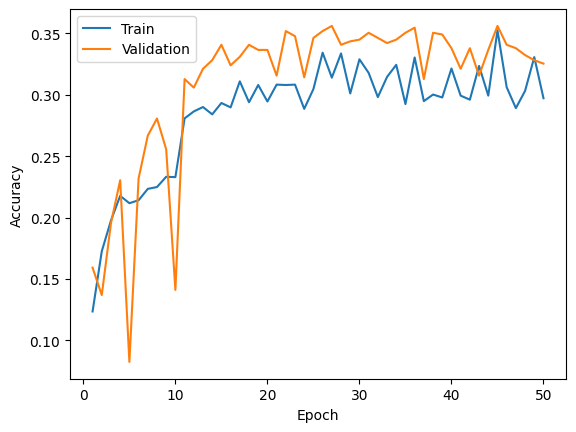

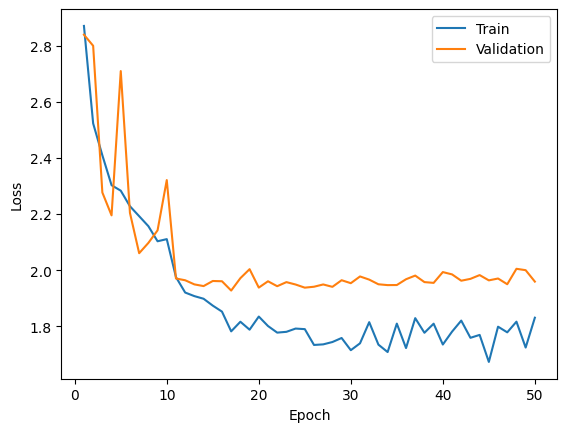

In [146]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs+1), train_acc_history, label='Train')
plt.plot(range(1, num_epochs+1), val_acc_history, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(range(1, num_epochs+1), train_loss_history, label='Train')
plt.plot(range(1, num_epochs+1), val_loss_history, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [147]:
model.eval()
test_loss, test_corrects = 0.0, 0.0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        test_corrects += torch.sum(preds == labels).item()

test_loss = test_loss / len(test_dataset)
test_acc = test_corrects / len(test_dataset)

print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")

Test Loss: 1.9354 | Test Acc: 0.3134


---

In [193]:
torch.save(model.state_dict(),"model_torch_googlenet_2.pth")